In [1]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


from scipy.integrate import odeint
from numpy import sin, copy, zeros, float32

from matplotlib import pyplot

Using TensorFlow backend.
/home/sam/miniconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sam/miniconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sam/miniconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sam/miniconda3/envs/py36/l

In [2]:
class mass_spring_damper_model:
    def __init__(self, m, k, b, x_0):
        """Inits pendulum constants and initial state

        # Arguments
            m: Mass
            k: Spring coeff
            b: Friction coeff
            x_0: Initial state
        """

        self.m = m
        self.k = k
        self.b = b
        self.x_0 = x_0



    def ode(self, x, t, u):
        """Dynamic equations of pendulum

        # Arguments
            x: [position of mass, velocity of mass]
            t: Time steps for ode solving
            u: External force applied to the mass

        # Returns
            Derivative of internal states
        """

        # ODE of mass-spring-damper model
        pos, acc = x
        dxdt = [acc, -(self.b/self.m)*acc - (self.k/self.m)*pos + (1/self.m)*u]

        return dxdt



    def update(self, u):
        """Interface function for pendulum model

        # Arguments
            u: External force applied to the mass

        # Returns
            Position of mass
        """

        # Solving ODE with scipy library
        x = odeint(self.ode, self.x_0, [0,0.1], args=(u,))

        self.x_0 = x[1]

        return x[1,0]





class lstm_model:
    def __init__(self, model_shape, num_lookback, num_u, num_y):
        """Inits lstm model parameters

        # Arguments
            model_shape: List of cell number for each layer
            num_lookback: Number of lookback
            num_u: Number of inputs
            num_y: Number of predictions
        """
        # Input features of LSTM model
        self.x = zeros((1,num_lookback,num_u+num_y))

        # Creates LSTM model
        num_x = num_u + num_y
        num_layers = len(model_shape)

        self.model = Sequential()

        if self._equal(num_layers, 1):
            num_cells = model_shape[0]
            self.model.add(LSTM(num_cells, input_shape=(num_lookback,num_x)))

        else:
            num_cells = model_shape[0]
            self.model.add(LSTM(num_cells, input_shape=(num_lookback,num_x),
                                return_sequences=True))

            for num_cells in model_shape[1:-1]:
                self.model.add(LSTM(num_cells, return_sequences=True))

            num_cells = model_shape[-1]
            self.model.add(LSTM(num_cells))

        self.model.add(Dense(num_y))
        self.model.compile(loss='mse', optimizer='adam')

        self.model.summary()



    def _equal(self, val_1, val_2):
        """Equality check function

        # Arguments
            val_1: First value for equality
            val_2: Second value for equality

        # Returns
            Equality result
        """

        condition_1 = (val_1 > (val_2-0.0001))
        condition_2 = (val_1 < (val_2+0.0001))

        return condition_1 and condition_2



    def _reshape(self, x_data, y_data):
        """Reshapes training data for LSTM

        # Arguments
            x_data: Features data
            y_data: Prediction data

        # Returns
            Reshaped x_data and y_data
        """

        x_data = copy(x_data)
        y_data = copy(y_data)

        # Gets dimension sizes from LSTM model
        _, num_lookback, num_x = self.model.layers[0].input_shape
        _, num_y = self.model.layers[-1].output_shape

        # Creates a new x_data
        new_shape = (x_data.shape[0], x_data.shape[1]-num_lookback,
                     num_lookback, num_x)
        x_data_new = zeros(new_shape, dtype=float32)

        x_data = x_data[:,1:,]

        # Fills new x_data
        for time_index in range(x_data_new.shape[1]):
            x_data_new[:,time_index,:,0:num_x-num_y] = x_data[:,time_index:time_index+num_lookback]
            x_data_new[:,time_index,:,num_x-num_y:num_x] = y_data[:,time_index:time_index+num_lookback]

        # Creates a new y data
        y_data_new = y_data[:,num_lookback:,]

        return x_data_new, y_data_new



    def fit(self, x_data, y_data, num_epochs, validation_split=0.2):
        """Trains LSTM model

        # Arguments
            x_data: Features data
            y_data: Prediction data
            num_epochs: Number of epochs
            validation_split: Number of validation sample / Number of training sample
        """

        x_data = copy(x_data)
        y_data = copy(y_data)

        # Reshapes data for LSTM model
        x_data, y_data = self._reshape(x_data, y_data)

        _, num_lookback, num_x = self.model.layers[0].input_shape
        _, num_y = self.model.layers[-1].output_shape

        x_data = x_data.reshape(-1, num_lookback, num_x)
        y_data = y_data.reshape(-1)


        # Trains LSTM model
        checkpoint = ModelCheckpoint('temp_model.h5', save_best_only=True)
        self.model.fit(x_data, y_data, epochs=num_epochs,
                       verbose=1, validation_split=validation_split,
                       callbacks=[checkpoint,])

        self.lstm_model = load_model('temp_model.h5')




    def update(self, u):
        """Interface function for LSTM model

        # Arguments
            u: Input value

        # Returns
            Prediction of LSTM model
        """
        # Fills input
        self.x[0,:-1,0] = self.x[0,1:,0]
        self.x[0,-1,0] = u

        # Predicts output
        y_pred = self.model.predict(self.x)

        # Fills output
        self.x[0,:-1,1] = self.x[0,1:,1]
        self.x[0,-1,1] = y_pred

        return y_pred[0]

In [3]:
from numpy import cumsum, zeros, random, float32
from matplotlib import pyplot

In [4]:
num_samples = 256 #1024
num_timesteps = 64 #64
split_ratio = 0.2

In [5]:
m = 1
k = 8
b = 0.8
x_0 = [0, 0]

In [6]:
model_shape= [8, 4]
num_lookback = 4
num_epochs = 32

In [7]:
x_data = cumsum(random.rand(num_samples,num_timesteps,1)-0.5, axis=1)
y_data = zeros(x_data.shape, dtype=float32)

In [8]:
for sample_index, input_signal in enumerate(x_data):
    # Creates dynamic pendulum model
    msd = mass_spring_damper_model(m, k, b, x_0)

    for time_index, u in enumerate(input_signal):
        y_data[sample_index, time_index] = msd.update(u)

In [9]:
x_test = x_data[:int(num_samples*split_ratio),]
y_test = y_data[:int(num_samples*split_ratio):,]
x_train = x_data[int(num_samples*split_ratio):,]
y_train = y_data[int(num_samples*split_ratio):,]

print('x_train.shape..:', x_train.shape)
print('y_train.shape..:', y_train.shape)

x_train.shape..: (205, 64, 1)
y_train.shape..: (205, 64, 1)


No handles with labels found to put in legend.


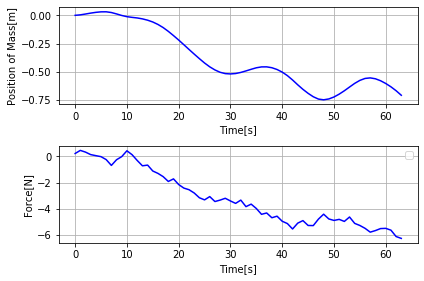

In [10]:
pyplot.subplot(2,1,1)
pyplot.plot(y_train[0,], 'b')
pyplot.xlabel('Time[s]')
pyplot.ylabel('Position of Mass[m]')
pyplot.grid()

# Plot one input signal
pyplot.subplot(2,1,2)
pyplot.plot(x_train[0,], 'b')
pyplot.xlabel('Time[s]')
pyplot.ylabel('Force[N]')
pyplot.legend(loc='best')
pyplot.grid()

pyplot.tight_layout()
pyplot.show()

In [11]:
num_u = x_train.shape[2]
num_y = y_train.shape[2]

In [12]:
lstm = lstm_model(model_shape, num_lookback, num_u, num_y)
lstm.fit(x_train, y_train, num_epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 8)              352       
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 565
Trainable params: 565
Non-trainable params: 0
_________________________________________________________________
Train on 9840 samples, validate on 2460 samples
Epoch 1/32
9840/9840 [==============================] - 2s 193us/step - loss: 0.0107 - val_loss: 0.0035
Epoch 2/32
9840/9840 [==============================] - 1s 132us/step - loss: 0.0031 - val_loss: 0.0028
Epoch 3/32
9840/9840 [==============================] - 1s 129us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 4/32
9840/9840 [==========================

In [13]:
y_pred = zeros(y_test.shape)

In [14]:
for sample_index in range(x_test.shape[0]):
    for time_index in range(x_test.shape[1]):
        y_pred[sample_index, time_index] = lstm.update(x_test[sample_index,time_index,0])

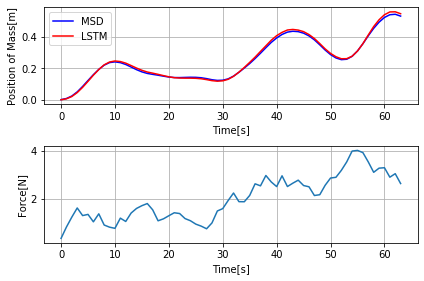

In [15]:
pyplot.subplot(2,1,1)
pyplot.plot(y_test[0,:,0], 'b', label='MSD')
pyplot.plot(y_pred[0,:,0], 'r', label='LSTM')
pyplot.xlabel('Time[s]')
pyplot.ylabel('Position of Mass[m]')
pyplot.legend(loc='best')
pyplot.grid()

# Plots requested torque by PID controller
pyplot.subplot(2,1,2)
pyplot.plot(x_test[0,:,0])
pyplot.xlabel('Time[s]')
pyplot.ylabel('Force[N]')
pyplot.grid()

pyplot.tight_layout()
pyplot.show()

In [16]:
y_pred

array([[[ 6.07703347e-04],
        [ 7.00155320e-03],
        [ 2.15196796e-02],
        ...,
        [ 5.59552968e-01],
        [ 5.60497224e-01],
        [ 5.48314452e-01]],

       [[ 5.04981637e-01],
        [ 4.34706360e-01],
        [ 3.57652396e-01],
        ...,
        [-7.76544452e-01],
        [-7.97661006e-01],
        [-8.15507948e-01]],

       [[-8.14668059e-01],
        [-7.58246005e-01],
        [-6.90785885e-01],
        ...,
        [ 1.44711770e-02],
        [ 3.75357307e-02],
        [ 6.11478724e-02]],

       ...,

       [[ 3.68327081e-01],
        [ 3.79797727e-01],
        [ 3.70691210e-01],
        ...,
        [ 9.07129422e-02],
        [ 1.10004663e-01],
        [ 1.23226427e-01]],

       [[ 1.23575859e-01],
        [ 1.12683214e-01],
        [ 9.49765220e-02],
        ...,
        [ 2.28053123e-01],
        [ 2.40760803e-01],
        [ 2.52389193e-01]],

       [[ 2.52106458e-01],
        [ 2.39422917e-01],
        [ 2.17159435e-01],
        ...,
        